# Implementing Advantage-Actor Critic (A2C) - 4 pts

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames, stack them together, prepares for PyTorch and normalizes to [0, 1]) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function.

- https://github.com/arinaruck/RL-2021/blob/1c7bc4051012ca2fe82ebbab4700253d07a18ce8/a2c_optional.ipynb
- https://github.com/450586509/reinforcement-learning-practice/blob/e8d060990d2fb98218d090bc8f121503992be3b2/07_A2C.ipynb
- https://github.com/alex-kozinov/courses/blob/ea5ffc79f7b1cd7203f066c532215d916c2a5dce/practical-rl/06_policy_based/a2c-optional.ipynb
- https://github.com/denklewer/yandex-rl-tasks/blob/d396e070300ca8811ad86196e1a8d4f142471c75/Hometasks/actor-critic/a2c-optional.ipynb

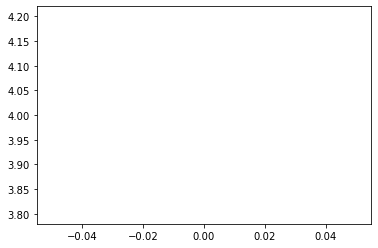

In [1]:
#!g1.1
import matplotlib.pyplot as plt
plt.plot([4])

In [2]:
#!g1.1
import numpy as np
from scipy.signal import convolve, gaussian

from collections import defaultdict
from tqdm import trange

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

from runners import EnvRunner
from atari_wrappers import nature_dqn_env

import matplotlib
matplotlib.rcParams['axes.grid'] = True

In [3]:
#!g1.1
nenvs = 8   # change this if you have more than 8 CPU ;)

env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=nenvs)

n_actions = env.action_space.spaces[0].n
obs = env.reset()
assert obs.shape == (nenvs, 4, 84, 84)
assert obs.dtype == np.float32

In [4]:
#!g1.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Next, we will need to implement a model that predicts logits of policy distribution and critic value. Use shared backbone. You may use same architecture as in DQN task with one modification: instead of having a single output layer, it must have two output layers taking as input the output of the last hidden layer (one for actor, one for critic). 

Still it may be very helpful to make more changes:
* use orthogonal initialization with gain $\sqrt{2}$ and initialize biases with zeros;
* use more filters (e.g. 32-64-64 instead of 16-32-64);
* use two-layer heads for actor and critic or add a linear layer into backbone;

**Danger:** do not divide on 255, input is already normalized to [0, 1] in our wrappers!

In [5]:
#!g1.1
class Agent(nn.Module):
    def __init__(self, state_shape, n_actions, n_features):
        super(Agent, self).__init__()
        
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.n_features = n_features
        self.body = self.network_body(state_shape[1], n_features)
        self.logits_h = self.logits_head()
        self.v_h = self.v_head()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        
    @staticmethod
    def  __init_weights(m):
        if type(m) in (nn.Linear, nn.Conv2d):
            nn.init.orthogonal_(m.weight.data, np.sqrt(2.0))
            if m.bias is not None:
                m.bias.data.fill_(0)
    
    
    def network_body(self, channels, out_features):
        model = nn.Sequential(nn.Conv2d(channels, 32, kernel_size=8, stride=4),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, kernel_size=4, stride=2),
                              nn.ReLU(),
                              nn.Conv2d(64, 64, kernel_size=3, stride=1),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(64 * 7 * 7, out_features),
                              nn.ReLU())
        model = model.apply(self.__init_weights)
        return model
    
    
    def logits_head(self):
        model = nn.Linear(self.n_features, self.n_actions).apply(self.__init_weights)
        return model
    
    
    def v_head(self):
        model = nn.Linear(self.n_features, 1).apply(self.__init_weights)
        return model
        
        
    def forward(self, states):
        '''
        input:
            states - tensor, (batch_size x channels x width x height)
        output:
            logits - tensor, logits of action probabilities for your actor policy, (batch_size x num_actions)
            V - tensor, critic estimation, (batch_size)
        '''
        x = torch.tensor(states, device=self.device)
        x = self.body(x)
        logits = self.logits_h(x)
        V = self.v_h(x)
        V = V.squeeze()
        return logits, V

You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a **dictionary** of all the arrays that are needed to interact with an environment and train the model.

**Important**: "actions" will be sent to environment, they must be numpy array or list, not PyTorch tensor.

Note: you can add more keys, e.g. it can be convenient to compute entropy right here.

In [6]:
#!g1.1
class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs):
        '''
        input:
            inputs - numpy array, (batch_size x channels x width x height)
        output: dict containing keys ['actions', 'logits', 'log_probs', 'values']:
            'actions' - selected actions, numpy, (batch_size)
            'logits' - actions logits, tensor, (batch_size x num_actions)
            'log_probs' - log probs of selected actions, tensor, (batch_size)
            'values' - critic estimations, tensor, (batch_size)
        '''
        logits, V = self.model.forward(inputs)
        probs = F.softmax(logits, 1)
        log_probs = F.log_softmax(logits, 1)
        actions = torch.multinomial(probs, num_samples=1).cpu().detach().numpy().flatten()
        log_probs_array = log_probs[range(inputs.shape[0]), actions]
        
        return {
            "actions": actions,
            "logits": logits,
            "log_probs": log_probs_array,
            "values": V,
            "probs": probs,
            "clear_log_probs": log_probs
        }

Next we will pass the environment and policy to a runner that collects rollouts from the environment. 
The class is already implemented for you.

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'dones'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory, or rollout length. Let's have a look at how it works.

In [7]:
#!g1.1
model = Agent(obs.shape, n_actions, 512).to(device)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=5)

In [8]:
#!g1.1
# generates new rollout
trajectory = runner.get_next()

In [9]:
#!g1.1
# what is inside
print(trajectory.keys())

dict_keys(['actions', 'logits', 'log_probs', 'values', 'probs', 'clear_log_probs', 'observations', 'rewards', 'dones'])


In [10]:
#!g1.1
# Sanity checks
assert 'logits' in trajectory, "Not found: policy didn't provide logits"
assert 'log_probs' in trajectory, "Not found: policy didn't provide log_probs of selected actions"
assert 'values' in trajectory, "Not found: policy didn't provide critic estimations"
assert trajectory['logits'][0].shape == (nenvs, n_actions), "logits wrong shape"
assert trajectory['log_probs'][0].shape == (nenvs,), "log_probs wrong shape"
assert trajectory['values'][0].shape == (nenvs,), "values wrong shape"

for key in trajectory.keys():
    assert len(trajectory[key]) == 5, \
    f"something went wrong: 5 steps should have been done, got trajectory of length {len(trajectory[key])} for '{key}'"

Now let's work with this trajectory a bit. To train the critic you will need to compute the value targets. It will also be used as an estimation of $Q$ for actor training.

You should use all available rewards for value targets, so the formula for the value targets is simple:

$$
\hat v(s_t) = \sum_{t'=0}^{T - 1}\gamma^{t'}r_{t+t'} + \gamma^T \hat{v}(s_{t+T}),
$$

where $s_{t + T}$ is the latest observation of the environment.

Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 

**Do not forget** to use `trajectory['dones']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step.

**Bonus (+1 pt):** implement [Generalized Advantage Estimation (GAE)](https://arxiv.org/pdf/1506.02438.pdf) instead; use $\lambda \approx 0.95$ or even closer to 1 in experiment. 

In [11]:
#!g1.1
class ComputeValueTargets:
    def __init__(self, policy, gamma=0.99):
        self.policy = policy
        self.gamma = gamma

    def __call__(self, trajectory, latest_observation):
        '''
        This method should modify trajectory inplace by adding 
        an item with key 'value_targets' to it
        
        input:
            trajectory - dict from runner
            latest_observation - last state, numpy, (num_envs x channels x width x height)
        '''
        V = self.policy.act(latest_observation)['values']
        rewards = trajectory['rewards']
        dones = trajectory['dones']
        target_values = []
        for r, done in reversed(list(zip(rewards, dones))):
            r = torch.tensor(r, device=V.device)
            done = torch.tensor(done, device=V.device)
            V = torch.where(done,
                            V * self.gamma + r,
                            r)
            target_values.append(V)
        trajectory['value_targets'] = target_values[::-1]    
        return trajectory

After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`.

You need to make sure that after this transformation `"log_probs"`, `"value_targets"`, `"values"` are 1-dimensional PyTorch tensors.

In [12]:
#!g1.1
class MergeTimeBatch:
    """ Merges first two axes typically representing time and env batch. """
    def __call__(self, trajectory, latest_observation):
        # Modify trajectory inplace. 
        for k, v in trajectory.items():
            if k in ["log_probs", "value_targets", "values", "probs", "clear_log_probs"]:
                trajectory[k] = torch.stack(v).flatten()
            else: 
                continue
        return trajectory

Let's do more sanity checks!

In [13]:
#!g1.1
runner = EnvRunner(env, policy, nsteps=5, transforms=[ComputeValueTargets(policy),
                                                      MergeTimeBatch()])

trajectory = runner.get_next()

In [14]:
#!g1.1
# More sanity checks
assert 'value_targets' in trajectory, "Value targets not found"
assert trajectory['log_probs'].shape == (5 * nenvs,)
assert trajectory['value_targets'].shape == (5 * nenvs,)
assert trajectory['values'].shape == (5 * nenvs,)

assert trajectory['log_probs'].requires_grad, "Gradients are not available for actor head!"
assert trajectory['values'].requires_grad, "Gradients are not available for critic head!"

Now is the time to implement the advantage actor critic algorithm itself. You can look into [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and lectures ([part 1](https://www.youtube.com/watch?v=Ds1trXd6pos&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=5), [part 2](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=6)) by Sergey Levine.

In [15]:
#!g1.1
class A2C:
    def __init__(self, policy, optimizer, value_loss_coef=0.25, entropy_coef=0.1, max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
    
    def loss(self, trajectory, write, write_res=False):
        # compute all losses
        # do not forget to use weights for critic loss and entropy loss
        advantage = trajectory['value_targets'] - trajectory['values']
        
        policy_loss = -torch.mean(trajectory['log_probs'] * advantage.detach())
        value_loss = advantage.detach().pow(2).mean()
        entropy_loss = torch.sum(trajectory['probs'] * trajectory['clear_log_probs'], -1).mean()
        
        loss = policy_loss + self.value_loss_coef * value_loss + entropy_loss * self.entropy_coef

        # log all losses
#         write('losses', {
#             'policy loss': policy_loss.cpu().detach().numpy(),
#             'critic loss': value_loss.cpu().detach().numpy(),
#             'entropy loss': entropy_loss.cpu().detach().numpy()
#         })
        
#         # additional logs
#         write('critic/advantage', torch.mean(advantage).detach().cpu().numpy())
#         write('critic/values', {
#             'value predictions': torch.mean(trajectory['values']).cpu().detach().numpy(),
#             'value targets': torch.mean(trajectory['value_targets']).cpu().detach().numpy(),
#         })
        if write_res:
            results = {
                'policy loss': policy_loss.cpu().detach().numpy(),
                'critic loss': value_loss.cpu().detach().numpy(),
                'entropy loss': entropy_loss.cpu().detach().numpy(),
                'loss': loss.cpu().detach().numpy(),
                'critic/advantage': torch.mean(advantage).cpu().detach().numpy(),
                'value predictions': torch.mean(trajectory['values']).cpu().detach().numpy(),
                'value targets': torch.mean(trajectory['value_targets']).cpu().detach().numpy()
            }
        else:
            results = {}

        return loss, results               

    def train(self, runner, write_res=False):
        # collect trajectory using runner
        # compute loss and perform one step of gradient optimization
        # do not forget to clip gradients
        trajectory = runner.get_next()
        loss, results = self.loss(trajectory, runner.write, write_res=write_res)
        
        loss.backward()
        grad_norm = clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.optimizer.zero_grad()
        # use runner.write to log scalar to tensorboard
#         runner.write('gradient norm', grad_norm.cpu().detach().numpy())
        if write_res:
            results['gradient norm'] = grad_norm.cpu().detach().numpy()
        return results

Now you can train your model. For optimization we suggest you use RMSProp with learning rate 7e-4 (you can also linearly decay it to 0), smoothing constant (alpha in PyTorch) equal to 0.99 and epsilon equal to 1e-5.

We recommend to train for at least 10 million environment steps across all batched environments (takes ~3 hours on a single GTX1080 with 8 CPU). It should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last episodes in each environment in the batch) of about 600. **Your goal is to reach 500**.

Notes:
* if your reward is stuck at ~200 for more than 2M steps then probably there is a bug
* if your gradient norm is >10 something probably went wrong
* make sure your `entropy loss` is negative, your `critic loss` is positive
* make sure you didn't forget `.detach` in losses where it's needed
* `actor loss` should oscillate around zero or near it; do not expect loss to decrease in RL ;)
* you can experiment with `nsteps` ("rollout length"); standard rollout length is 5 or 10. Note that this parameter influences how many algorithm iterations is required to train on 10M steps (or 40M frames --- we used frameskip in preprocessing).

In [16]:
#!g1.1
def evaluate(env, policy, n_games=1, t_max=10000):
    '''
    Plays n_games and returns rewards
    '''
    rewards = []
    
    for _ in range(n_games):
        s = env.reset()
        
        R = 0
        for _ in range(t_max):
            action = policy.act(np.array([s]))["actions"][0]
            
            s, r, done, _ = env.step(action)
            
            R += r
            if done:
                break

        rewards.append(R)
    return np.array(rewards)

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

def linear_decay(init_val, final_val, cur_step, total_steps):
    if cur_step >= total_steps:
        return final_val
    return (init_val * (total_steps - cur_step) +
            final_val * cur_step) / total_steps

In [17]:
#!g1.1
nsteps = 10
nenvs = 8
total_steps = 10000000 // nenvs // nsteps
eval_freq = 2000
update_freq = 50
init_lr = 7e-4
final_lr = 7e-6

env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=nenvs)

total_data = {'policy loss': [],
              'critic loss': [],
              'entropy loss': [],
              'loss': [],
              'reward': [],
              'gradient norm': []}

In [18]:
#!g1.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Agent(obs.shape, n_actions, 512).to(device)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=10, transforms=[ComputeValueTargets(policy),
                                                      MergeTimeBatch()])

optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)

a2c = A2C(policy, optimizer)

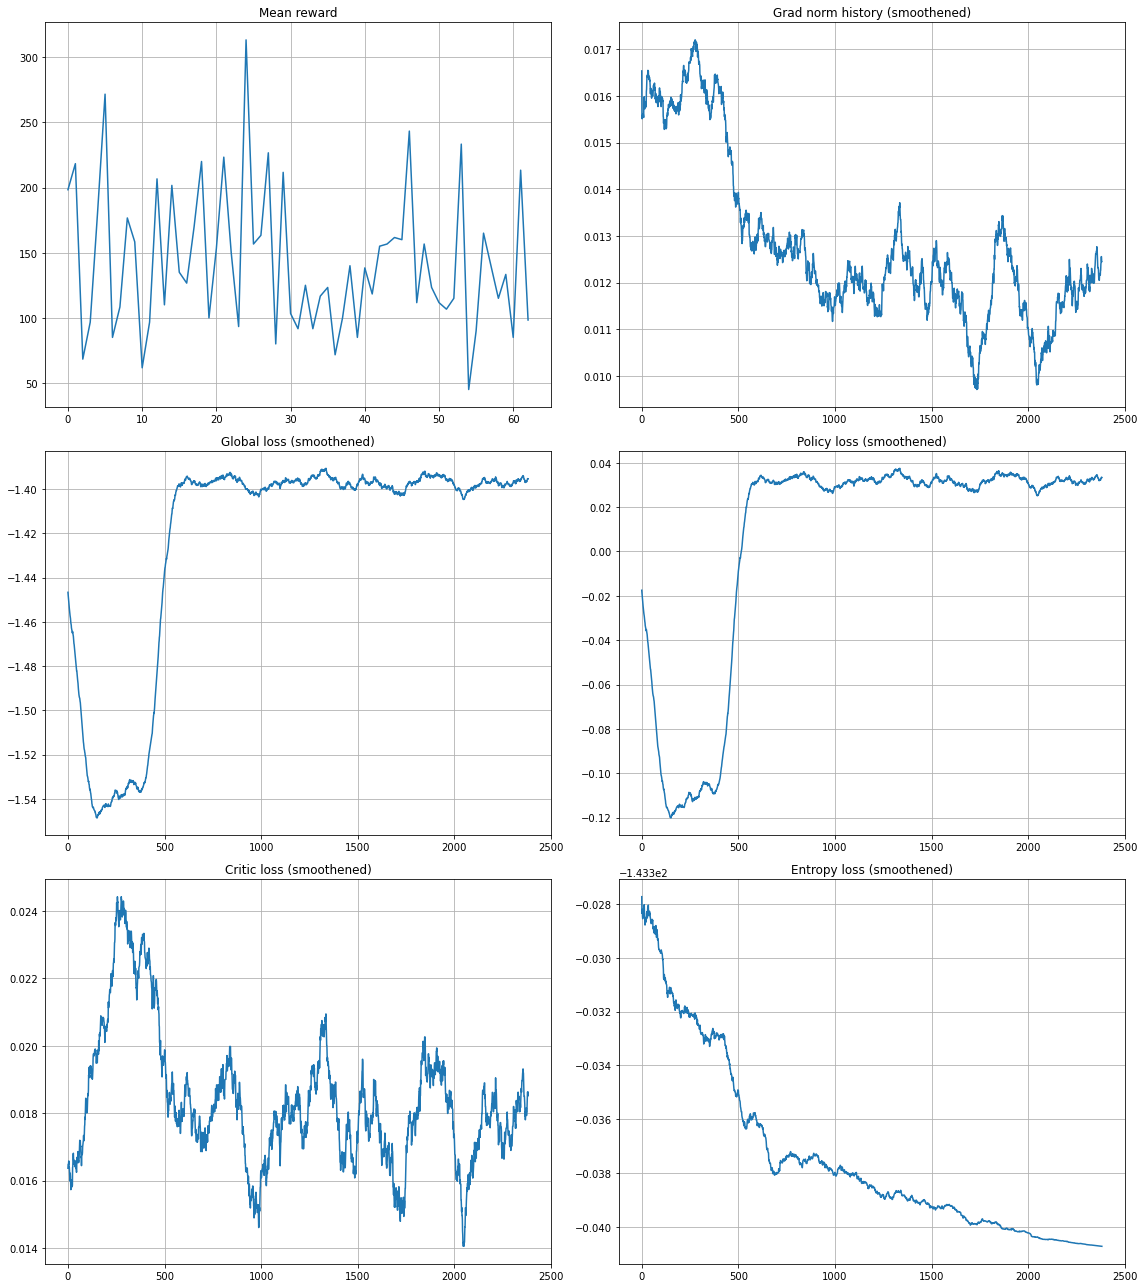

100%|██████████| 125000/125000 [8:04:16<00:00,  4.30it/s]  


In [19]:
#!g1.1
for step in trange(total_steps):
    lr = linear_decay(init_lr, final_lr, step, total_steps)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-5)
    a2c.optimizer = optimizer
    
    write_res = step % update_freq == 0
    res = a2c.train(runner, write_res)
    
    if step % update_freq == 0:
        total_data['policy loss'].append(res['policy loss'])
        total_data['critic loss'].append(res['critic loss'])
        total_data['entropy loss'].append(res['entropy loss'])
        total_data['loss'].append(res['loss'])
        total_data['gradient norm'].append(res['gradient norm'])
        
    if step % eval_freq == 0:
        env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, 
                     clip_reward=False, summaries=False, episodic_life=False)
        total_data['reward'].append(np.mean(evaluate(env, policy, n_games=3)))
        env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=nenvs)
            
            
        clear_output(True)
        plt.figure(figsize=[16, 18])
        
        plt.subplot(3, 2, 1)
        plt.title("Mean reward")
        plt.plot(total_data['reward'])
        
        plt.subplot(3, 2, 2)
        plt.title("Grad norm history (smoothened)")
        plt.plot(smoothen(total_data['gradient norm']))
        
        plt.subplot(3, 2, 3)
        plt.title("Global loss (smoothened)")
        plt.plot(smoothen(total_data['loss']))
        
        plt.subplot(3, 2, 4)
        plt.title("Policy loss (smoothened)")
        plt.plot(smoothen(total_data['policy loss']))
        
        plt.subplot(3, 2, 5)
        plt.title("Critic loss (smoothened)")
        plt.plot(smoothen(total_data['critic loss']))
        
        plt.subplot(3, 2, 6)
        plt.title("Entropy loss (smoothened)")
        plt.plot(smoothen(total_data['entropy loss']))
        
        plt.tight_layout()
        plt.show()

In [20]:
#!g1.1
# save your model just in case 
torch.save(model.state_dict(), "A2C")    

In [21]:
#!g1.1
env.close()

In [22]:
#!g1.1
# загрузка модели
# model = Agent(obs.shape, n_actions, 512)
# model.load_state_dict(torch.load("A2C"))

# policy = Policy(model)

## Evaluation

In [23]:
#!g1.1
env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, 
                     clip_reward=False, summaries=False, episodic_life=False)

# evaluation will take some time!
sessions = evaluate(env, policy, n_games=30)
score = sessions.mean()
print(f"Your score: {score}")

assert score >= 500, "Needs more training?"
print("Well done!")

Your score: 148.33333333333334


AssertionError: Needs more training?

In [24]:
#!g1.1
env.close()

## Record

In [25]:
#!g1.1
env_monitor = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, monitor=True,
                             clip_reward=False, summaries=False, episodic_life=False)

In [26]:
#!g1.1
# record sessions
sessions = evaluate(env_monitor, policy, n_games=3)

In [27]:
#!g1.1
# rewards for recorded games
sessions

array([120.,  95., 105.])

In [28]:
#!g1.1
env_monitor.close()